# Imports

In [237]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

# Fetch Data

In [238]:
# Data Extraction
start_date = "2020-06-11"
end_date = "2023-06-11"
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" ]]

[*********************100%***********************]  1 of 1 completed


In [239]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

print("Length: ", len(df))

Length:  754


# Add Moving Average

In [240]:
df["12_MA"] = df["Close"].rolling(window=12).mean()
df["21_MA"] = df["Close"].rolling(window=21).mean()

# Train/Test Split Data

In [241]:
# Drop NA
df = df.dropna()

# Split Data into Two sets
train_amount = len(df)//2
test_amount = len(df) - train_amount

x_train = df[["Returns" , "Range"]].iloc[:train_amount]
x_test = df[["Returns" , "Range"]].iloc[test_amount:]
save_df = df.iloc[test_amount:]



print(f"Train Data Length: {len(x_train)}")
print(f"Test Data Length: {len(x_test)}")

Train Data Length: 367
Test Data Length: 367


# Train HMM

In [242]:
# Train Hidden Markov Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
train = model.train([np.array(x_train.values)])

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Test HMM

In [243]:
# Test Hidden Markov Model
test = model.predict([x_train.values])[0]

# Test Predictions

In [244]:
df_main = save_df.copy()
df_main.drop(columns = ["High" , "Low"], inplace = True)

hmm_results = model.predict([x_train.values])[0]
df_main["HMM"] = hmm_results

# Run BackTest
- if the 12 day moving average is greater than the 21 day moving average, place signal
    -  1 : go long
    -  0 : do nothing
    - -1 : go short

In [245]:
# Signals
df_main.loc[df_main["12_MA"] > df_main["21_MA"] , "MA_Signal" ] = 1
df_main.loc[df_main["12_MA"] <= df_main["21_MA"] , "MA_Signal" ] = 0

# Decide Favorable States

In [336]:
# Check Each row to see if within positive signals from HMM    

# HARDCODED FAVORABLE STATES 
favorable_states = [0,3]


hmm_values = df_main["HMM"].values

# 0 if no   ||   1 if yes
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]


df_main["HMM_Signal"] = hmm_values

In [337]:
# Add Combined "Main" Signal   (if moving average and HMM signals are green)
df_main["Main_Signal"] = 0
df_main.loc[   (df_main["MA_Signal"] == 1) &  (df_main["HMM_Signal"] == 1 ), "Main_Signal" ] = 1

df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [338]:
# Benchmmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exponent"] = np.exp(df_main["bench_prod"]) - 1

In [339]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exponent"] = np.exp(df_main["lrets_prod"]) - 1


# Review Results


In [340]:
df_main.dropna(inplace=True)


df_main.tail(10)

,Open,Close,Returns,Range,12_MA,21_MA,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exponent,lrets_strat,lrets_prod,strat_prod_exponent
Date,,,,,,,,,,,,,,,,
2023-05-12,413.420013,411.589996,-0.001310,0.011172,411.725833,411.552856,1,1.0,0,0.0,-0.001311,-0.128312,-0.120421,-0.000000,0.032172,0.032695
2023-05-15,412.220001,413.010010,0.003450,0.007800,411.775833,411.579048,2,1.0,0,0.0,0.003444,-0.124868,-0.117387,-0.000000,0.032172,0.032695
2023-05-16,411.859985,410.250000,-0.006683,0.006289,411.302500,411.403333,0,0.0,1,0.0,-0.006705,-0.131573,-0.123285,0.000000,0.032172,0.032695
2023-05-17,412.350006,415.230011,0.012139,0.012712,411.279167,411.451906,2,0.0,0,0.0,0.012066,-0.119507,-0.112643,0.000000,0.032172,0.032695
2023-05-18,414.899994,419.230011,0.009633,0.012058,411.978335,411.694287,2,1.0,0,0.0,0.009587,-0.109920,-0.104095,0.000000,0.032172,0.032695
2023-05-19,420.170013,418.619995,-0.001455,0.008075,412.861669,412.015238,0,1.0,1,0.0,-0.001456,-0.111377,-0.105398,-0.000000,0.032172,0.032695
2023-05-22,418.640015,418.790009,0.000406,0.007284,414.000003,412.329048,2,1.0,0,1.0,0.000406,-0.110970,-0.105035,-0.003733,0.028439,0.028847
2023-05-23,417.079987,414.089996,-0.011223,0.012183,414.121668,412.398571,1,1.0,0,0.0,-0.011286,-0.122257,-0.115079,-0.000000,0.028439,0.028847
2023-05-24,412.420013,411.089996,-0.007245,0.007173,413.984169,412.637143,1,1.0,0,0.0,-0.007271,-0.129528,-0.121490,0.000000,0.028439,0.028847


# Calculate Metrics

In [341]:
# Sharpe Ratio Function
def sharpe_ratio_calc(returns_series):
    TradingDays = 255
    TradingDays_SQRT = np.sqrt(TradingDays)
    risk_free_rate = 0.01
    mean = returns_series.mean() * TradingDays
    sigma = returns_series.std() * TradingDays_SQRT
    sharpe_ratio = round((mean - risk_free_rate) / sigma , 2 )
    return sharpe_ratio

In [342]:
# Metrics
bench_returns = round(df_main["bench_prod_exponent"].values[-1] * 100 , 1)
strategy_returns = round(df_main["strat_prod_exponent"].values[-1] * 100 , 1)


bench_sharpe = sharpe_ratio_calc(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio_calc(df_main["lrets_strat"].values)

In [343]:
# Print metrics
print(f"Returns Benchmark: {bench_returns}%")
print(f"Returns Strategy: {strategy_returns}%")

print("-------------------")

print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")



print("\n\n Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'")

Returns Benchmark: -11.4%
Returns Strategy: 2.9%
-------------------
Sharpe Benchmark: -0.44
Sharpe Strategy: 0.39


 Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'


# Plot Results

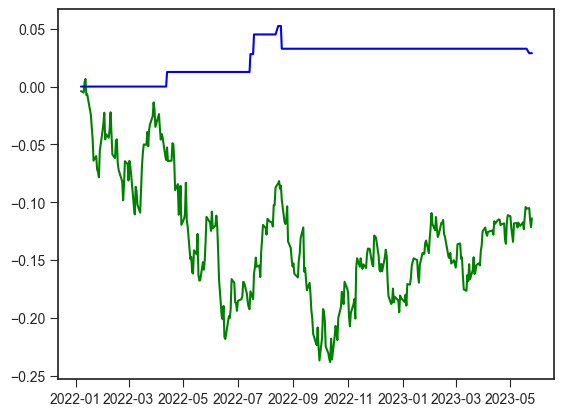

In [344]:
# Plot Equity Curves
fig = plt.Figure(figsize=(18,10))
plt.plot(df_main["bench_prod_exponent"], color="green" )
plt.plot(df_main["strat_prod_exponent"] , color="blue")

plt.show()

# SAVE DATA

In [345]:
df_main.to_csv(f"data-storage/HMM-{symbol}.csv")